In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Simple quantum-bit transformation to bloch coordinate


In [2]:
zero = np.array([1, 0])
one = np.array([0, 1])

In [3]:
a = 1 + 0j
b = 0 + 1j

# normalize the vectors
r = np.sqrt(np.abs(a) ** 2 + np.abs(b) ** 2)

a = a / r
b = b / r

psi = a * zero + b * one
psi

array([0.70710678+0.j        , 0.        +0.70710678j])

In [4]:
phi_a = np.angle(a)
phi_b = np.angle(b)
r_a = np.abs(a)
r_b = np.abs(b)

phi = phi_b - phi_a
theta = 2 * np.arccos(r_a)

psi_bloch = np.cos(theta / 2) * zero + np.exp(1j * phi) * np.sin(theta / 2) * one

assert np.allclose(psi, psi_bloch), "Calculations are wrong"

psi_bloch

array([7.07106781e-01+0.j        , 4.32978028e-17+0.70710678j])

In [5]:
print(f"phi_a = {(phi_a * 180j / np.pi):.2f}°")

phi_a = 0.00+0.00j°


In [6]:
def convert_to_bloch(psi: np.ndarray):
    a = psi[0]
    b = psi[1]
    phi_a = np.angle(a)
    phi_b = np.angle(b)
    r_a = np.abs(a)
    r_b = np.abs(b)
    phi = phi_b - phi_a
    theta = 2 * np.arccos(r_a)
    if np.isnan(theta):
        theta = 2 * np.arcsin(r_b)
    return np.array([theta / 2, phi])

In [7]:
def qubit_to_cartesian(qubit: np.ndarray):
    # map a qubit to spherical coordinates
    return np.array(
        [
            2 * np.real(qubit[1] * np.conj(qubit[0])),
            2 * np.imag(qubit[1] * np.conj(qubit[0])),
            np.abs(qubit[0]) ** 2 - np.abs(qubit[1]) ** 2,
        ]
    )

In [8]:
from gate import Gate
from state import State

In [9]:
def cartesian_to_polar(vector):

    [x, y, z] = vector

    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return np.array([theta, phi, r])

In [10]:
X_gate = Gate(np.array([[0, 1], [1, 0]]))
Y_gate = Gate(np.array([[0, -1j], [1j, 0]]))
Z_gate = Gate(np.array([[1, 0], [0, -1]]))
H_gate = Gate(1 / np.sqrt(2) * np.array([[1, 1], [1, -1]]))

NameError: name 'calculate_trajectory' is not defined

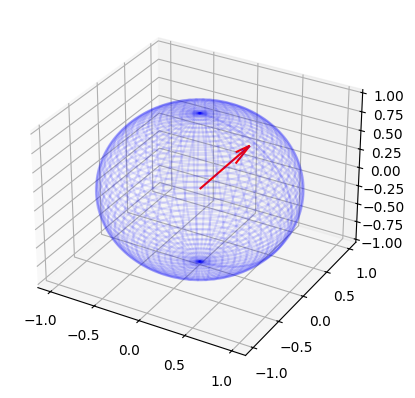

In [11]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# plot the bloch sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color="b", alpha=0.1)

gate = Gate("Y")
state_from = Gate("H") * State("0")
p_from = qubit_to_cartesian(state_from)
p_to = qubit_to_cartesian(gate * state_from)

# plot the rotation axis of the X gate
ax.quiver(0, 0, 0, *(-gate.rotation_axis), color="r", label="Rotation axis")

# draw the path with center axis being the rotation axis and angle being the rotation angle

[x, y, z] = calculate_trajectory(gate, state_from, 100)

ax.plot(x, y, z, color="g", label="Trajectory")

ax.quiver(0, 0, 0, *p_from, color="b", label="Initial state")
ax.quiver(0, 0, 0, *p_to, color="r", label="Final state")

ax.set_aspect("equal")
ax.legend()

plt.title(f"Trajectory of the {gate} gate applied to the state {state_from}")

plt.show()

In [12]:
Gate("H") * State("0")

|+>